## Hourly Time Series Forecasting Using FaceBook's Prophet
[FaceBook Prophet Documentation](http:facebook.github.io/prophet/docs/quick_start.html)

In [1]:
!pip install -q prophet

# Error Metrics in Machine Learning: MSE, MAE, and MAPE

In machine learning and statistical modeling, error metrics are essential for assessing the accuracy of predictive models. Three common metrics are **Mean Squared Error (MSE)**, **Mean Absolute Error (MAE)**, and **Mean Absolute Percentage Error (MAPE)**. Each provides a different perspective on model accuracy, depending on the requirements of the analysis.

---

### 1. Mean Squared Error (MSE)
**Mean Squared Error** is the average of the squares of the errors. It calculates the average of the squared differences between predicted and actual values. MSE is defined as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2
$$

where:
- \(y_{i}\): actual value
- \(hat{y}_{i}\): predicted value
- \(n\): number of observations

**Usage**: MSE is often used in regression problems as it penalizes larger errors more heavily than smaller ones, making it useful when you want to focus on reducing large errors. However, MSE is sensitive to outliers due to squaring errors, which can exaggerate their impact.

**Interpretation**: Lower MSE values indicate a model with better predictive accuracy, as it means the model's predictions are closer to the actual values on average.

---

### 2. Mean Absolute Error (MAE)
**Mean Absolute Error** is the average of the absolute differences between predicted and actual values. It is calculated as:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|
$$

**Usage**: MAE is a robust error metric as it treats all errors equally, making it less sensitive to outliers compared to MSE. It’s commonly used when all prediction errors should have equal weight, regardless of their size.

**Interpretation**: Like MSE, a lower MAE suggests better model accuracy. MAE is also more interpretable, as it represents the average prediction error in the same units as the target variable.

---

### 3. Mean Absolute Percentage Error (MAPE)
**Mean Absolute Percentage Error** expresses prediction errors as percentages, which can be useful for comparing model performance across different datasets. MAPE is calculated as:

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_{i} - \hat{y}_{i}}{y_{i}} \right| \times 100
$$

**Usage**: MAPE is used when understanding the error as a percentage is beneficial, especially in fields like finance or economics where relative errors are more meaningful than absolute errors. However, MAPE can be sensitive to very small actual values, as they can produce high percentage errors.

**Interpretation**: A lower MAPE indicates better model performance, with values often interpreted directly as percentage error. MAPE is commonly used to understand the error rate and interpret model accuracy in relative terms.

---

### Summary
Each of these error metrics offers unique insights:
- **MSE** penalizes larger errors more heavily, making it sensitive to outliers.
- **MAE** is a straightforward average of absolute errors, offering robustness against outliers.
- **MAPE** provides percentage-based errors, useful for models where relative accuracy is more informative.

Choosing the right metric depends on the problem at hand and the specific requirements of the predictive model.


In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Prophet with the updated package name
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Set a consistent style for plots (choose one for best appearance)
plt.style.use('fivethirtyeight')  # 'fivethirtyeight' style for a clean, modern look

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## Types of Time Series

* **Purely Random Error**
  - This type of time series has no recognizable pattern, trend, or seasonality. The values fluctuate randomly around a constant mean and are independent of time.
  - Since there is no underlying structure to capture or predict, attempting to model this type of time series is typically futile. Such data might represent purely random noise or independent, identically distributed (i.i.d.) random values.
  - **Example**: Measurement errors in an experiment, where the values fluctuate randomly without any discernible trend.

* **Curvilinear Trend**
  - A curvilinear trend is a non-linear trend that increases or decreases at a varying rate over time. It can follow patterns like quadratic (parabolic) or exponential curves.
  - Quadratic trends form a U-shaped or inverted-U pattern, while exponential trends show rapid growth or decay.
  - This type of trend often indicates compounding growth or decay in the data, where values change at an accelerating rate.
  - **Example**: Population growth over time, which often follows an exponential trend as the population grows faster with each generation.

* **Increasing Linear Trend**
  - An increasing linear trend is a straight-line pattern showing a consistent upward movement in the data over time.
  - This trend suggests a steady rate of change and can often be observed in data where growth or increase happens at a constant rate.
  - Such trends are relatively easy to model and predict since they are based on a simple, consistent upward slope.
  - **Example**: Annual revenue growth of a business that is increasing at a constant rate over time.

* **Seasonal Pattern**
  - A seasonal pattern is a repeating fluctuation in data that occurs at regular intervals, often driven by time-based factors like seasons, months, weeks, or days.
  - Seasonal patterns are common in time series data influenced by recurring events (e.g., holidays or weather changes) that impact behavior cyclically.
  - This pattern typically has a fixed period, such as a weekly, monthly, or yearly cycle, and is characterized by predictable highs and lows within each period.
  - **Example**: Retail sales peaking during the holiday season and dipping in the off-season, reflecting a seasonal shopping pattern.

* **Seasonal Pattern with Linear Growth**
  - This type of time series combines both a seasonal pattern and a linear trend. It shows regular seasonal fluctuations superimposed on a steady upward or downward linear trend.
  - Over time, the seasonal highs and lows may increase or decrease in amplitude as the overall trend grows or declines linearly.
  - This pattern is common in industries where there is both an overall growth trend and seasonal fluctuations affecting demand or behavior.
  - **Example**: Monthly electricity consumption in a growing city, where there is increased usage during summer and winter (seasonal pattern), but with a general upward trend as the population grows over the years.

![Types of Time Series](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

## Data

The dataset used consists of hourly power consumption data from the PJM East region, covering the period from 2002 to 2018. PJM, an organization managing electric grid operations across multiple U.S. states, provides detailed energy usage records, which exhibit distinctive patterns influenced by time and weather.

### Key Characteristics of Energy Consumption Data

1. **Seasonal Trends**: Energy consumption typically peaks during summer and winter due to heating and cooling demands, showing clear seasonal cycles.
  
2. **Daily Cyclic Patterns**: Hourly data reveal daily fluctuations, with higher usage during daytime and early evening hours compared to nighttime hours.

3. **Holidays and Weekends**: Demand often drops on holidays and weekends compared to weekdays, reflecting reduced industrial and commercial activity.

4. **Long-term Trends**: Factors such as population growth, urban development, and technological advancements influence gradual changes in consumption over the years.

### Forecasting with Prophet

Exploring this data with Prophet, a time series forecasting model, allows for automatic detection of seasonality, trends, and holidays. Prophet’s flexibility in handling seasonalities makes it particularly suitable for identifying and adapting to these patterns in energy consumption data. This approach aids in generating forecasts that adapt to both short- and long-term trends, providing valuable insights for energy management and demand forecasting.

In [3]:
# Load the data
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')

# Convert the 'Datetime' column to datetime format and set it as the index
pjme['Datetime'] = pd.to_datetime(pjme['Datetime'])
pjme.set_index('Datetime', inplace=True)

# Display the first few rows of the dataframe
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


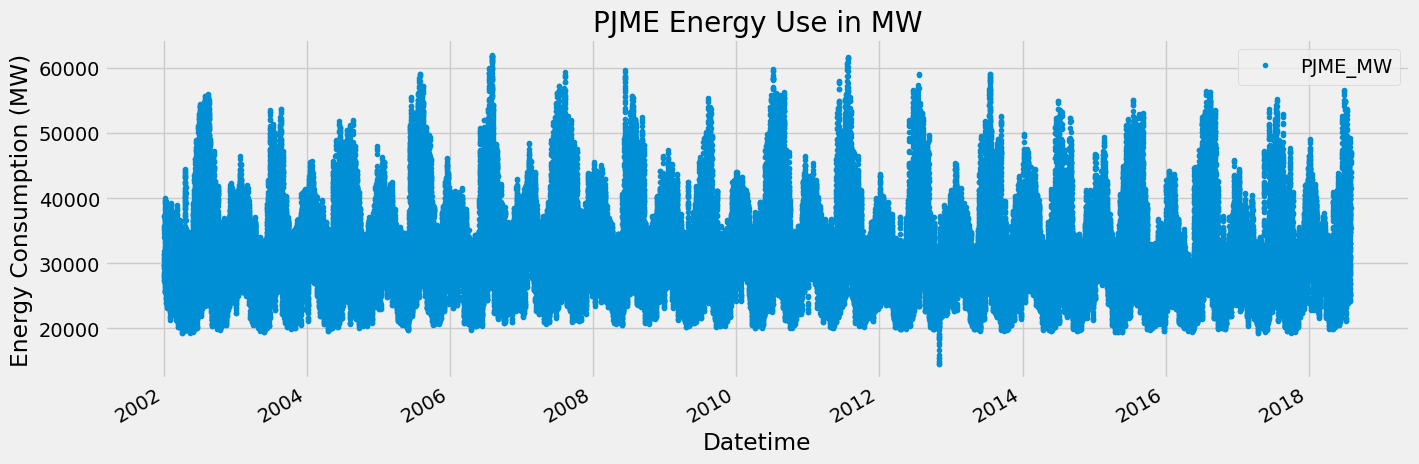

In [4]:
# Set color palette
color_pal = sns.color_palette()

# Plotting the PJME energy use data with specific styling options
ax = pjme.plot(
    style=".",                    # Use dots to represent each data point on the plot
    figsize=(15, 5),              # Set the figure size to 15 inches wide by 5 inches tall
    color=color_pal[0],           # Use the first color from the color palette for the plot points
    title="PJME Energy Use in MW" # Set the title of the plot to indicate the data being displayed
)

# Add axis labels
ax.set_xlabel("Datetime")
ax.set_ylabel("Energy Consumption (MW)")

# Display the plot
plt.show()

## Time Series Features

Creating robust time series features is essential to accurately model patterns and trends inherent in temporal data. These features often capture seasonal, weekly, and daily patterns that help the model better understand changes over time. In this feature creation process, we focus on deriving key temporal attributes from the datetime index, including hours, days, months, quarters, and years. By doing so, we enable the model to leverage cyclical and seasonal trends, which are common in time-based data like energy consumption.

### Key Features Explained:

1. **Hour**: Extracting the hour allows the model to capture daily patterns, such as peak and off-peak usage times.

2. **Day of the Week**: By identifying the day of the week, the model can learn weekly patterns, such as increased consumption on weekdays versus weekends. For added structure, we treat days as ordered categorical data, enabling a clear differentiation between them.

3. **Day and Month**: Extracting specific day and month information helps capture monthly or date-specific trends, which can be relevant for certain behaviors tied to calendar events.

4. **Quarter and Year**: Adding the quarter and year allows the model to detect long-term trends and seasonal cycles. This is particularly useful for datasets that span multiple years, where annual cycles are significant.

5. **Day of Year**: Capturing the ordinal position of the day within the year gives the model additional seasonal insight, which can be important for seasonal variations within the year itself.

6. **Weekend Indicator**: By creating a binary feature to indicate weekends, the model can distinguish between weekday and weekend consumption patterns. This is particularly relevant in industries where demand differs significantly on weekends.

7. **Season**: Assigning each record to a season (e.g., Winter, Spring, Summer, Fall) helps the model learn broader seasonal trends, which are essential in cases where temperature or season-specific factors influence the data. To ensure consistency, the seasons are treated as ordered categories.

### Visualization of Patterns by Day and Season

Visualizing the data by day and season can further clarify consumption trends. For instance, by plotting energy consumption across days of the week and seasons, we can observe how demand fluctuates by day and season. Such visual insights reveal cyclical patterns, highlighting peak days and seasonal trends, which provide context for interpreting model predictions and understanding key demand drivers in the data.

In [5]:
from pandas.api.types import CategoricalDtype

# Define categorical types for ordered days and seasons
day_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
season_type = CategoricalDtype(categories=['Winter', 'Spring', 'Summer', 'Fall'], ordered=True)

def create_features(df, label=None):
    '''Optimized function to create time series features from datetime index'''
    df = df.copy()
    df['date'] = df.index

    # Extracting date components directly using vectorized operations
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.day_name().astype(day_type)
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
    
    # Determine season using vectorized numpy select for efficiency
    conditions = [
        df['month'].isin([12, 1, 2]),
        df['month'].isin([3, 4, 5]),
        df['month'].isin([6, 7, 8]),
        df['month'].isin([9, 10, 11])
    ]
    choices = ['Winter', 'Spring', 'Summer', 'Fall']
    df['season'] = np.select(conditions, choices, default='Unknown')
    df['season'] = df['season'].astype(season_type)  # Convert to categorical after selection

    # Optionally add label
    if label:
        df[label] = df[label]
    
    # Drop unnecessary column
    df.drop(columns=['date'], inplace=True)

    return df

pjme_features = create_features(pjme)

In [6]:
# Display the first few rows
pjme_features.head()

,PJME_MW,hour,day_of_week,day,month,quarter,year,day_of_year,is_weekend,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,Tuesday,31,12,4,2002,365,0,Winter
2002-12-31 02:00:00,25147.0,2,Tuesday,31,12,4,2002,365,0,Winter
2002-12-31 03:00:00,24574.0,3,Tuesday,31,12,4,2002,365,0,Winter
2002-12-31 04:00:00,24393.0,4,Tuesday,31,12,4,2002,365,0,Winter
2002-12-31 05:00:00,24860.0,5,Tuesday,31,12,4,2002,365,0,Winter


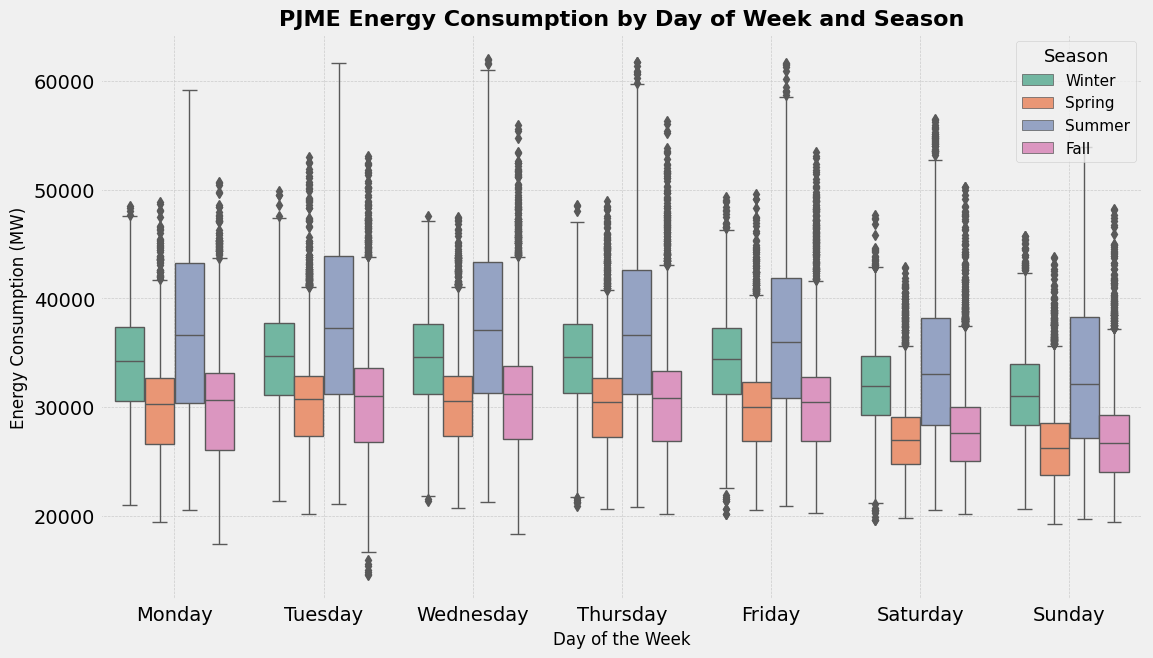

In [7]:
# Create a boxplot with improved styling and information
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(
    data=pjme_features.dropna(),
    x='day_of_week',  # Change 'Weekday' to 'day_of_week' if that’s the column name
    y='PJME_MW',
    hue='season',
    ax=ax,
    linewidth=1,
    palette='Set2'  # Use a color palette for better distinction of seasons
)

# Add titles and labels for clarity
ax.set_title("PJME Energy Consumption by Day of Week and Season", fontsize=16, fontweight='bold')
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12)
ax.legend(title='Season', title_fontsize='13', fontsize='11')  # Customize legend for clarity

# Rotate x-axis labels for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.show()

## Train / Test Split

In time series modeling, splitting data into training and testing sets is crucial for evaluating the model's performance on unseen data. Unlike random splits in standard machine learning tasks, a chronological split is used in time series to respect the temporal order of events.

In this case, we split the dataset at **January 1, 2015**. All data before this date serves as the **training set**, while data after it forms the **test set**. This split allows the model to learn from past patterns in the training set and test its ability to forecast future values in the test set.

### Visualization of Train vs Test Split

The visualization shows the energy consumption data for both the training and test sets, highlighting where the split occurs. Different colors distinguish the two sets, allowing us to see any patterns or trends that the model may need to generalize in the future.

By plotting both sets together, we gain insights into the continuity and consistency of the data, which can help us ensure that the split effectively separates past patterns from future predictions.

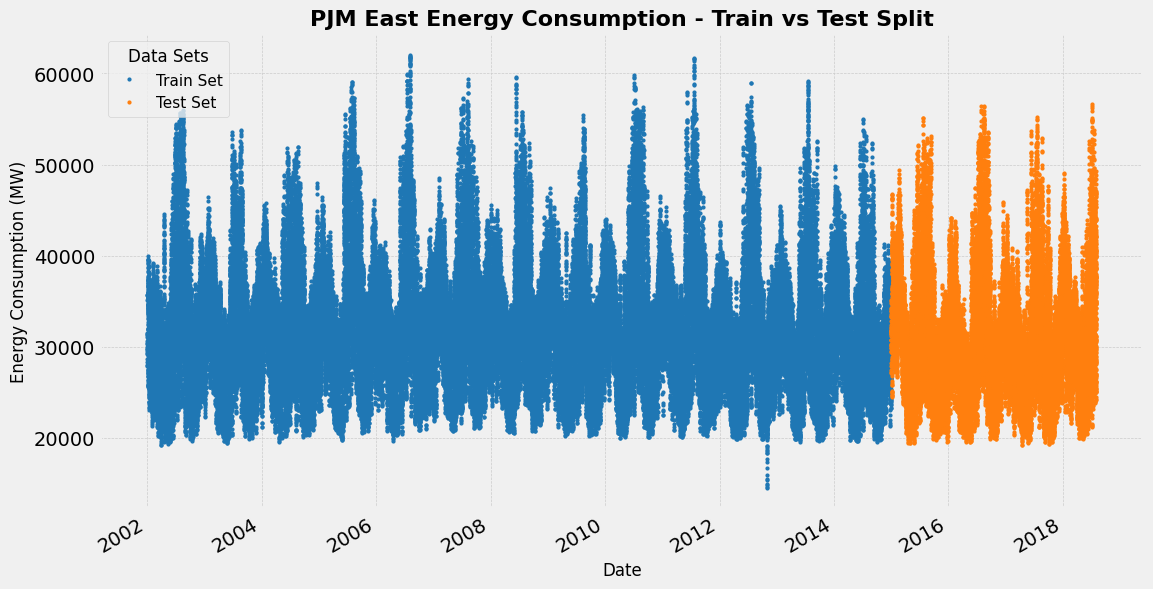

In [8]:
# Split date for train and test sets
split_date = '2015-01-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Rename columns and combine train and test sets for plotting
train = pjme_train.rename(columns={'PJME_MW': 'Train Set'})
test = pjme_test.rename(columns={'PJME_MW': 'Test Set'})
pjme_combined = train.join(test, how='outer')

# Plotting the combined data
fig, ax = plt.subplots(figsize=(12, 7))
pjme_combined.plot(
    ax=ax,
    style=['.', '.'],
    color=['#1f77b4', '#ff7f0e'],  # Colors for train and test sets
    markersize=4,
    title="PJM East Energy Consumption - Train vs Test Split"
)

# Add labels and grid for clarity
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12)
ax.set_title("PJM East Energy Consumption - Train vs Test Split", fontsize=16, fontweight='bold')
ax.legend(title="Data Sets", fontsize=11, title_fontsize=12, loc="upper left")

# Customize the grid and show the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.show()

## Simple Prophet Model

Prophet is a powerful forecasting tool developed by Facebook's data science team. It's designed for time series forecasting, particularly in scenarios with strong seasonal effects and multiple seasonality with daily, weekly, and yearly patterns. Prophet is known for being robust to missing data, and it handles outliers gracefully, making it a popular choice for business applications and complex datasets.

### Preparing Data for Prophet

The Prophet model requires the input dataset to follow a specific naming convention for its columns:
- **Datetime column**: Prophet expects the column containing datetime information to be named `ds`.
- **Target column**: The column holding the values we want to predict should be named `y`.

By renaming our columns accordingly, we ensure compatibility with Prophet's API. This step is essential since Prophet relies on these standardized column names to parse the time series data correctly.

### Steps for Building a Simple Prophet Model

1. **Rename Columns**: Adjust the column names in our dataset to `ds` for the datetime information and `y` for the target variable we aim to forecast.

2. **Define and Train the Model**: Initialize the Prophet model and fit it to the training data. Prophet automatically detects seasonality and trends in the data, allowing it to model complex time series patterns.

3. **Make Forecasts**: Once trained, the model can make future predictions over a specified horizon. Prophet generates forecasts along with confidence intervals, which can be useful for understanding the prediction uncertainty.

4. **Plot Forecast Results**: Prophet includes built-in plotting functionality to visualize both the forecasted values and the underlying seasonal patterns it identified, such as daily, weekly, and yearly trends.

### Example Workflow

- **Data Preparation**: First, filter and rename columns in our dataset as `ds` and `y`.
- **Initialize Model**: Instantiate the Prophet model, where you can optionally add extra seasonality if you know there are additional periodic patterns.
- **Fit Model**: Train the model on the training data.
- **Forecast Future Values**: Use the trained model to predict future values over a specified timeframe, such as the next month or year.
- **Visualize**: Plot the forecast alongside historical data to evaluate the model's fit and inspect seasonal components.

Using Prophet, we can capture complex seasonal trends in our data, making it easier to interpret and explain forecasted results, especially for business insights and strategic decision-making.

In [9]:
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

In [10]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

09:26:29 - cmdstanpy - INFO - Chain [1] start processing
09:27:52 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 8.41 s, sys: 547 ms, total: 8.96 s
Wall time: 1min 32s


In [11]:
pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23885.244140,32866.303995,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22648.536537,31503.942671,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21549.387153,30171.143954,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21084.395930,30319.674979,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,22398.883819,30983.593899,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


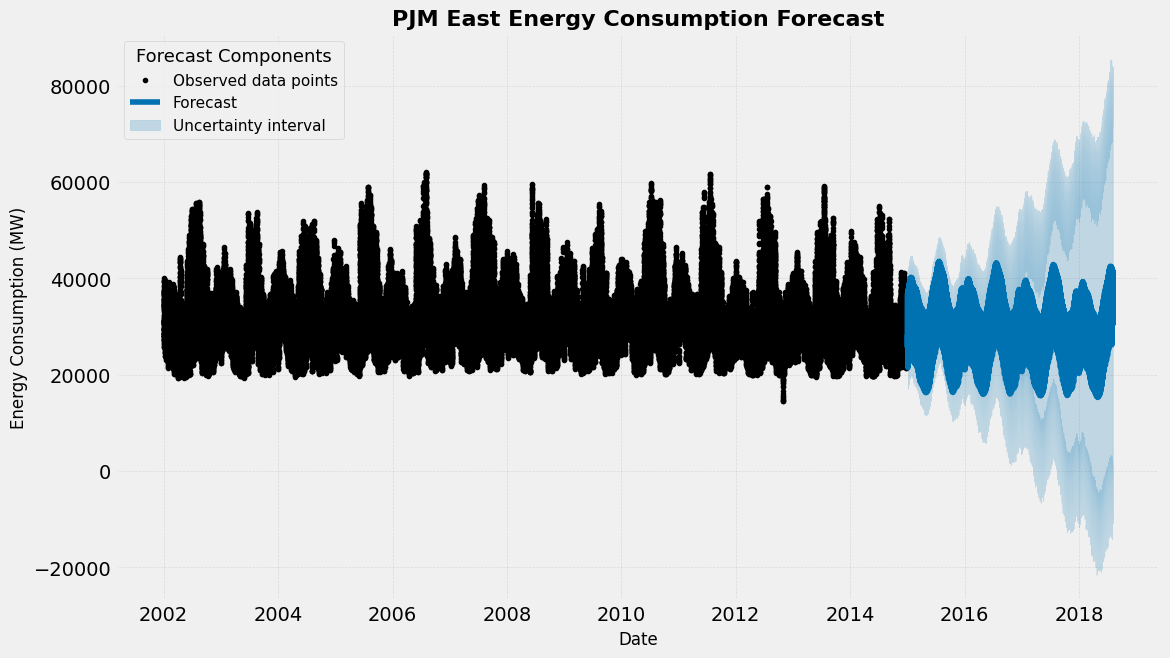

In [12]:
# Plot forecast with improved styling and additional information
fig, ax = plt.subplots(figsize=(12, 7))

# Plot forecast
model.plot(pjme_test_fcst, ax=ax)

# Customize the plot for clarity
ax.set_title("PJM East Energy Consumption Forecast", fontsize=16, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12)

# Customize legend to distinguish forecast components
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11, title="Forecast Components", title_fontsize=13, loc="upper left")

# Add gridlines for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

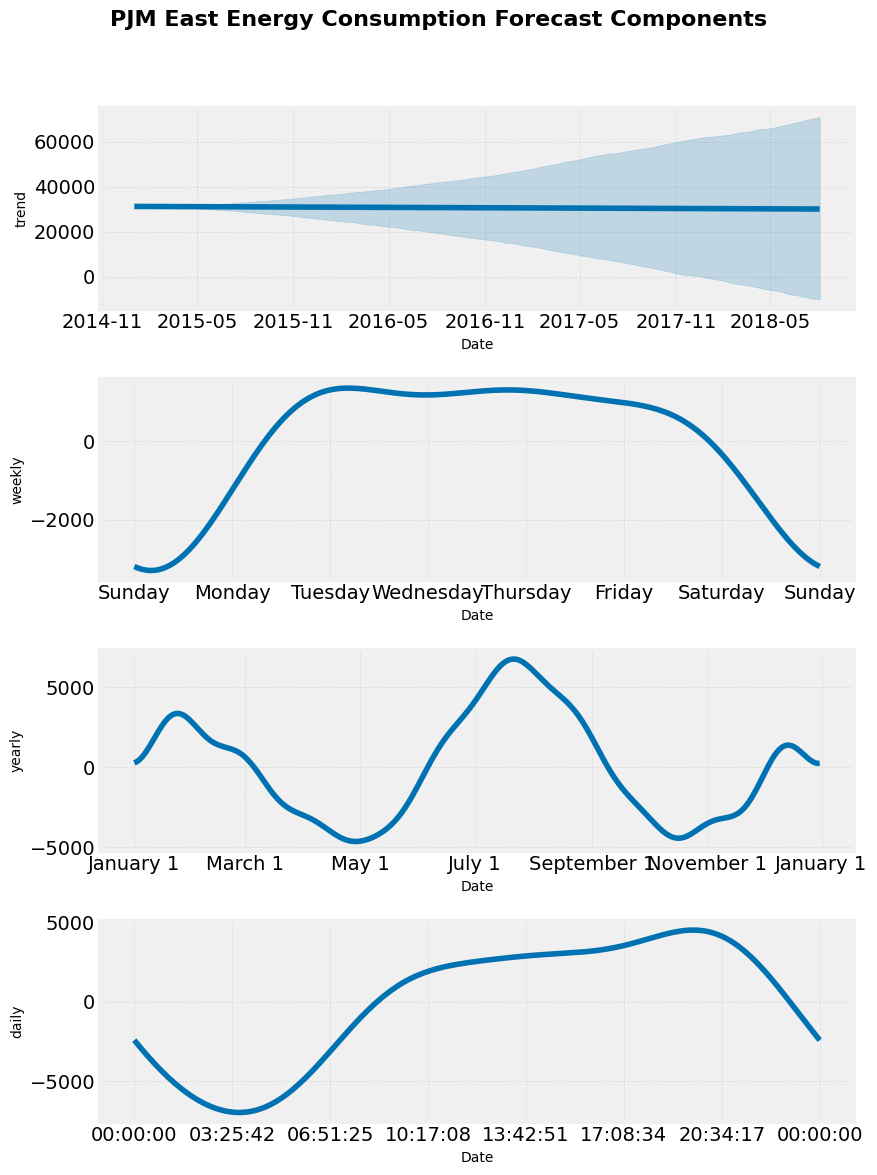

In [13]:
# Plot forecast components with better styling and layout
fig = model.plot_components(pjme_test_fcst)

# Adjust each subplot for improved readability and styling
fig.suptitle("PJM East Energy Consumption Forecast Components", fontsize=16, fontweight='bold')

# Access the individual axes to customize them
for ax in fig.get_axes():
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    
# Improve spacing between subplots for readability
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Show the plot
plt.show()

## Compare Forecast to Actuals

After building and fitting the Prophet model, it's crucial to evaluate how well the forecast aligns with the actual observed data. This comparison helps assess the model's accuracy and identify any potential areas for improvement. Here, we use a plot to visually compare the forecasted values against the actual test data.

### Plotting Forecast vs. Actuals

1. **Plot the Test Data**: We begin by plotting the actual test data points as red scatter points. This allows us to easily differentiate the observed values from the forecasted values, highlighting any deviations between them.

2. **Plot the Forecasted Data**: Using Prophet’s built-in plotting function, we add the model’s forecasted data to the same plot. This includes both the predicted values and confidence intervals, which give insight into the uncertainty around each forecasted point.

3. **Customize the Plot**: Adding titles and axis labels improves clarity, and a customized legend makes it easy to distinguish between the actual test data and the forecast. Additionally, gridlines are added to enhance readability, making it simpler to assess alignment between actual and predicted values over time.

### Interpretation

By comparing the forecasted values to the actual test data, we gain insight into the model's predictive accuracy. Ideally, the forecast line should closely follow the pattern of the actual data points, indicating that the model has captured the underlying patterns in the time series. Deviations between forecast and actuals may point to areas where the model could be fine-tuned, such as adding additional seasonal components or adjusting hyperparameters.

This comparison provides a straightforward visual evaluation, helping identify potential improvements to increase forecast accuracy.

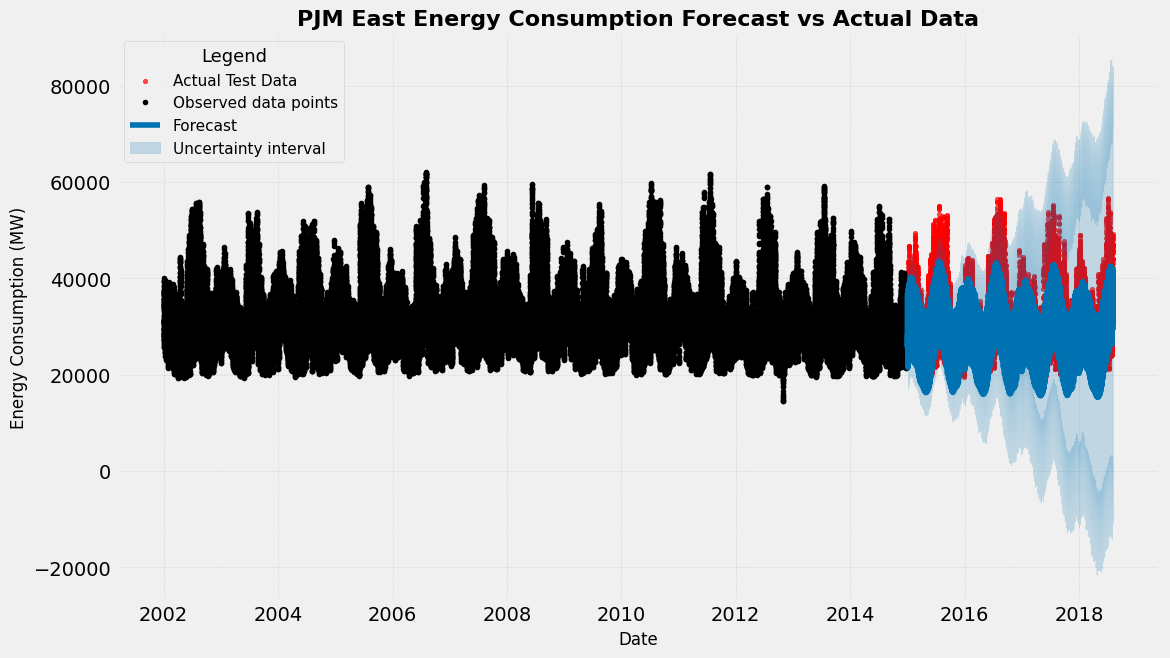

In [14]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the test data as red scatter points for easy identification
ax.scatter(
    pjme_test.index, pjme_test['PJME_MW'], 
    color='red', label='Actual Test Data', alpha=0.7, s=10
)

# Plot the forecast data from Prophet model
model.plot(pjme_test_fcst, ax=ax)

# Customize the plot for clarity
ax.set_title("PJM East Energy Consumption Forecast vs Actual Data", fontsize=16, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12)

# Update legend to include both forecast and actual data
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11, title="Legend", title_fontsize=13, loc="upper left")

# Add gridlines for better readability
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

## The error metrics provide insights into the model's forecast accuracy:

- **Mean Absolute Error (MAE)**: The model’s predictions differ from the actual power consumption values by an average of about 5182 MW. This provides a clear sense of the typical forecast error magnitude.

- **Mean Absolute Percentage Error (MAPE)**: The model's forecasts have an average error of approximately 16.5% relative to actual values. This percentage makes the accuracy easy to interpret, showing that on average, the forecasts are within 16.5% of the true values.

- **Root Mean Squared Error (RMSE)**: The model has an RMSE of around 6617 MW, which emphasizes larger errors. This metric reveals the impact of significant deviations, indicating that, while most errors may be smaller, there are some substantial discrepancies.

Lower values across these metrics indicate better model performance. Together, these metrics provide a well-rounded view of forecast quality, helping us identify areas for further model refinement.


In [15]:
mse = np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat']))
mse

6616.966074225221

In [16]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])
mae

5181.911537928106

In [17]:
mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])
mape

16.512003880182647